In [1]:
# Necessary imports
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from copy import deepcopy

In [2]:
# Some utility functions to read and extract data in desired format
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda index: (lbl[index], img[index])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image.reshape(28, 28), cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [3]:
# Reading the images
TRAIN = read('training', 'MNIST'); TEST = read('testing', 'MNIST')

In [4]:
img_train = []; lbl_train = []
img_test = []; lbl_test = []

for temp in TRAIN:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in TEST:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train);lbl_train = np.array(lbl_train)
img_test = np.array(img_test); lbl_test = np.array(lbl_test)

## The Dataset

Sneeking at a random image to gain confidence!

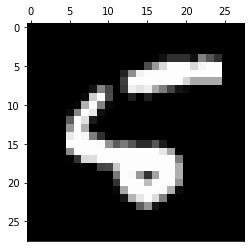

5


In [5]:
show(img_test[8])
print(lbl_test[8])

Wew... looks like it all worked out

### One hot encoding

In [6]:
lbl_train = np.eye(10)[lbl_train]
lbl_test = np.eye(10)[lbl_test]
lbl_test.shape

(10000, 10)

## Normalising the data


In [7]:
img_train = img_train / 255
img_test = img_test / 255

## The MLFNN

In [8]:
class Relu:

    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
    

class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.dimensions = dimensions
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activation_fns[i]
    
    def __deepcopy__(self, memo):
        deepcopy_method = self.__deepcopy__
        self.__deepcopy__ = None
        cp = deepcopy(self, memo)
        self.__deepcopy__ = deepcopy_method
        # custom treatments
        cp.weights = {}; cp.bais = {}
        for i in range(cp.n_layers - 1):
            cp.weights[i + 1] = np.random.randn(cp.dimensions[i], cp.dimensions[i + 1]) / np.sqrt(cp.dimensions[i])
            cp.bais[i + 1] = np.zeros(cp.dimensions[i + 1])

        return cp
    
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(activated[i], self.weights[i]) + self.bais[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(self, x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])
            _, _a = self.feed_forward(x)
            print("Epoch:", i + 1, "Loss:", self.loss.loss(y_true, _a[self.n_layers]), end='\r')
    
    def predict(self, x):
        _, a = self.feed_forward(x)
        return a[self.n_layers]

The above class allows us to create a network pf arbitary size and supports ReLU and Sigmoid as activations functions.

Cross-validation is used to determine the better model for this problem, the value of k is 5, i.e. we create 5 splits of the data set. We then will use the results obtained model contructed in each fold to find the better one.

In [9]:
X = np.copy(img_train)
Y = np.copy(lbl_train)

# Creating the 5 fold cross-validation 
kf = KFold(n_splits=5)
"""
We create a new model in each fold and train on 4 splits while we hold the 5th split for testing. We repeat this 
process for all the combinations. We store the accuracy for each split and discard the model. The model with 
better accuracy will the better suited for our problem.
"""

# Define the models
"""This neural network has 3 layers, 784 input neurons, 100 in the hidden layer, and 10 in the output layer.
We use a learning rate of 0.01 and a modest 100 epochs to get a rough idea aboyt the model"""
nn1 = NeuralNetwork((784, 100, 10), (Relu, Sigmoid))

"""This neural network has 4 layers, 784 input neurons, 64, 64 in the hidden layers, and 10 in the output layer.
We use a learning rate of 0.1 and a modest 100 epochs to get a rough idea aboyt the model"""
nn2 = NeuralNetwork((784, 64, 64, 10), (Sigmoid, Sigmoid, Sigmoid))

## The error array is used to hold the errors made in each fold.
e1 = []; e2 = []

In [11]:
i = 1
for train, test in kf.split(X):
    x = X[train]; y = Y[train]
    x_ = X[test]; y_ = Y[test]
    print("Split: ", i)
    i += 1
    nn1.learn(x, y, MSE, 100, 128, 0.01)
    print()
    y_pred = np.argmax(nn1.predict(x_), axis=1)
    y_true = np.argmax(y_, axis=1)
    e1.append(accuracy_score(y_true, y_pred))

Split:  1
Epoch: 100 Loss: 1.1687428501563933e-05
Split:  2


KeyboardInterrupt: 

The error of model 1:

In [ ]:
e1 = np.array(e1)
print("The mean error of the test-train split:", 1 - e1.mean())
print("The standard deviation of the test-train split", e1.std())

The error of model 2:

In [ ]:
e2 = np.array(e2)
print("The mean error of the test-train split:", 1 - e2.mean())
print("The standard deviation of the test-train split", e2.std())

In [ ]:
e1 = np.array(e1); e2 = np.array(e2)
print("Avg. accuracy of Model 1:", e1.mean(), "\nAvg. accuracy of Model 2:", e2.mean())

We can see that model one just, barely, performs better. We therefore choose, the first model to solve the problem.

## The Digit classifier

We have determined that the neural network #2 is the better one to perform classification. We will now train it to on the entire dataset.

We use each pixel as a feature to train the network. This results in a network that takes $28\times28$ number of pixels as input. We have two hidden layers each with 64 nuerons, activated by a Sigmoid function. Lastly, the output layer has 10 neuron which determine the class label of a given input image.

In [ ]:
# Choose the better model
if e1.mean() < e2.mean(): 
    nn_simple = deepcopy(nn1)
else:
    nn_simple = deepcopy(nn2)

# Train the network
nn_simple.learn(img_train, lbl_train, MSE, 500, 128, 0.01)

Some metrics of the model

In [ ]:
# Mak epredictions on the test set
y_pred = np.argmax(nn_simple.predict(img_test), axis=1)
# Get the true labels
y_true = np.argmax(lbl_test, axis=1)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, y_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(y_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(y_pred, y_true))

We have scored an accuracy of about 98%. From the precision column we note that all classes have high precision. This is also evident from the consfusion matrix.

With more epochs, it seems like there is a good chance of overfitting the model.